In [1]:
import os
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.io import fits
from astropy.convolution import convolve
from astropy.modeling.models import Sersic2D
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
from astropy.constants import c
from reproject import reproject_interp
from scipy.optimize import minimize, least_squares
from scipy.signal import fftconvolve, convolve2d
import dynesty
import dynesty.pool as dypool
from dynesty import plotting as dyplot
import dynesty.utils as dyutil
import pickle
import corner
from cmcrameri import cm
from multiprocessing import Pool
import importlib
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
# seed the random number generator
rstate = np.random.default_rng(111)

from glint.beam import cleanbeam_from_header
import glint.lensing as ls
from glint.context import ImageContext
from glint.forward import forward_model_image
from glint.inference import run_emcee
from glint.plotstyle import set_my_plot_style
from kinematics_params import param_names, param_table

In [2]:
set_my_plot_style()

In [3]:
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

## Data

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


hst peak: 8.0, 17.0 pix, corresponding to 0.160, 0.340 arcsec from the center
hst centroid: 4.7, 3.5 pix, corresponding to 0.093, 0.070 arcsec from the center
hst gaussian fit: 10.8, 14.5 pix, corresponding to 0.217, 0.290 arcsec from the center
Number of pixels in the mask: 26404
Number of channels: 12
Number of pixels in image plane: 201 x 201
Pixel scale in image plane: 0.02 arcsec/pixel


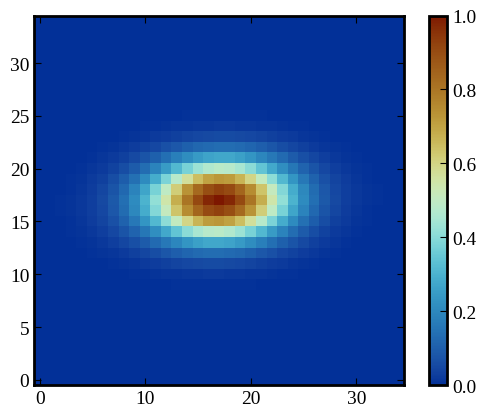

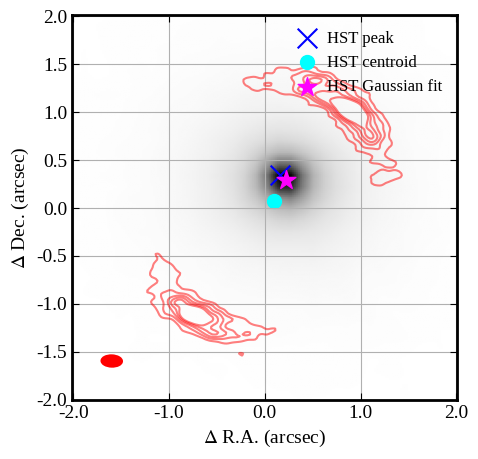

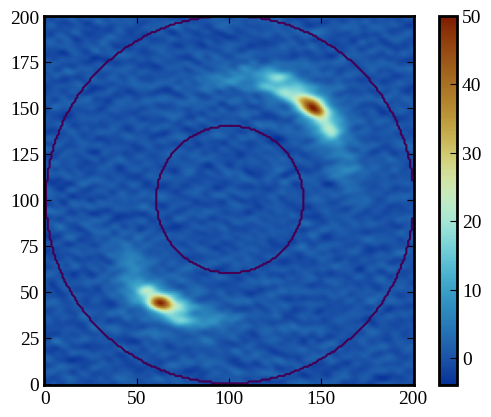

In [4]:
# image data
data_dir = Path("./data").resolve()
data_dir.exists()

obsfits   = str(data_dir / "B6_concat_CII_dv50km_rob-0.5_clean.image.pbcor.cutout.-250+300km.fits")
noisefits = str(data_dir / "B6_concat_CII_dv50km_rob-0.5_clean.noise.pbcor.cutout.-250+300km.fits")

obsdata, obsheader = fits.getdata(obsfits, header=True)
noisedata = fits.getdata(noisefits)
noisedata_inv = 1/noisedata
BMAJ, BMIN, BPA, CDELT = obsheader['BMAJ'], obsheader['BMIN'], obsheader['BPA'], obsheader['CDELT2']

beam = cleanbeam_from_header(35, obsheader)
plt.imshow(beam, origin="lower", cmap=cm.roma_r)
plt.colorbar()


#### Continuum data for overlay ####
contfits   = str(data_dir / "B6_concat_cont_rob-0.5_clean.image.pbcor.cutout.fits")
contnoisefits = str(data_dir / "B6_concat_cont_rob-0.5_clean.noise.pbcor.cutout.fits")

contdata, contheader = fits.getdata(contfits, header=True)
contnoisedata = fits.getdata(contnoisefits)
####

# あとは同じ
hst_fits = str(data_dir / "hst_skycell-p1356x14y05_wfc3_ir_f125w_coarse-all_drz.fits")
hst_data, hst_header = fits.getdata(hst_fits, header=True)
hst_wcs = WCS(hst_header)

# reproject to ALMA
hst_on_alma, footprint = reproject_interp((hst_data, hst_wcs), WCS(contheader, naxis=2), shape_out=contdata.shape)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(hst_on_alma, origin='lower', cmap='gray_r')
ax.contour(contdata/contnoisedata, levels=[4,8,12,16,20], colors='red', alpha=0.5)

# 画像の中心
ny, nx = contdata.shape
x0 = (nx - 1) / 2
y0 = (ny - 1) / 2
pixscale_as = abs(obsheader['CDELT2'] * 3600) # arcsec/pix
def format_func_x(x_pix, _):
    return f"{(x_pix - x0) * pixscale_as:.1f}"
def format_func_y(y_pix, _):
    return f"{(y_pix - y0) * pixscale_as:.1f}"
from matplotlib.ticker import FuncFormatter
ax.xaxis.set_major_formatter(FuncFormatter(format_func_x))
ax.yaxis.set_major_formatter(FuncFormatter(format_func_y))

# psfサイズをimage planeの左下に楕円として表示
xy_beam = (0.10*nx, 0.10*ny)
ellipse = Ellipse(xy=xy_beam, width=BMAJ/CDELT, height=BMIN/CDELT, angle=BPA+90, edgecolor='red', facecolor='red', lw=1.5)
ax.add_patch(ellipse)
ax.grid()

# HST peak
hst_peak = np.unravel_index(np.nanargmax(hst_on_alma), hst_on_alma.shape)
ax.scatter(hst_peak[1], hst_peak[0], marker='x', color='blue', s=200, label='HST peak')

# HST centroid
from photutils.centroids import centroid_com
y_com, x_com = centroid_com(hst_on_alma)
ax.scatter(x_com, y_com, marker='o', color='cyan', s=100, label='HST centroid')

# HST gaussian fit
def gauss2d(p, x, y):
    A, x0, y0, sx, sy, rho, c = p
    # 相関rho入り楕円ガウス：必要なければ rho=0 に固定
    X = (x - x0); Y = (y - y0)
    z = (X/sx)**2 + (Y/sy)**2 - 2*rho*X*Y/(sx*sy)
    return A*np.exp(-0.5/(1-rho**2) * z) + c
ny, nx = hst_on_alma.shape
yy, xx = np.indices((ny, nx))
p0 = [hst_on_alma.max(), x_com, y_com, 3.0, 3.0, 0.0, 0.0]
use = np.isfinite(hst_on_alma)
def resid(p): return (gauss2d(p, xx[use], yy[use]) - hst_on_alma[use])
res = least_squares(resid, p0, bounds=([0,0,0,0.5,0.5,-0.5,-np.inf],
                                       [np.inf,nx,ny,50,50,0.5,np.inf]))
A,x0_g,y0_g,sx,sy,rho,c = res.x
ax.scatter(x0_g, y0_g, marker='*', color='magenta', s=200, label='HST Gaussian fit')

ax.set_xlabel(r"$\Delta$ R.A. (arcsec)", fontsize=14)
ax.set_ylabel(r"$\Delta$ Dec. (arcsec)", fontsize=14)
ax.legend(fontsize=12)
print(f"hst peak: {hst_peak[1]-x0:.1f}, {hst_peak[0]-y0:.1f} pix, corresponding to {((hst_peak[1]-x0)*pixscale_as):.3f}, {((hst_peak[0]-y0)*pixscale_as):.3f} arcsec from the center")
print(f"hst centroid: {x_com-x0:.1f}, {y_com-y0:.1f} pix, corresponding to {((x_com-x0)*pixscale_as):.3f}, {((y_com-y0)*pixscale_as):.3f} arcsec from the center")
print(f"hst gaussian fit: {x0_g-x0:.1f}, {y0_g-y0:.1f} pix, corresponding to {((x0_g-x0)*pixscale_as):.3f}, {((y0_g-y0)*pixscale_as):.3f} arcsec from the center")

x0_l = (x0_g-x0)*pixscale_as
y0_l = (y0_g-y0)*pixscale_as


# mask definition
maskdata = np.zeros(contdata.shape).astype(bool)

# RMS基準にマスクを定義する場合
# thresh = 2
# maskdata[obsdata*noisedata_inv > thresh] = True

# 固定マスクを使う場合
# 円環マスク
r_inner = 0.8 # arcsec
r_outer = 2.0 # arcsec
y, x = np.indices(contdata.shape)
x_center = contdata.shape[1] / 2
y_center = contdata.shape[0] / 2
r = np.sqrt((x - x_center)**2 + (y - y_center)**2) * np.abs(CDELT) * 3600
maskdata[(r >= r_inner) & (r <= r_outer)] = True


Npix = np.nansum(maskdata)
print(f"Number of pixels in the mask: {Npix}")

# mask
# obsdata[maskdata==0] = np.nan
# noisedata_inv[maskdata==0] = np.nan

fig, ax = plt.subplots()
im = ax.imshow(contdata/contnoisedata, origin="lower", cmap=cm.roma_r)
ax.contour(maskdata)
fig.colorbar(im, ax=ax)



# source plane grid
ny_src, nx_src = 200, 200
pixsize_src = 0.005 # arcsec
x0_src, y0_src = 0.0, 0.0
xx_src, yy_src = ls.make_grid_arcsec(nx=nx_src, ny=ny_src, pixscale_arcsec=pixsize_src, x0_arcsec=x0_src, y0_arcsec=y0_src)

# image plane grid
nchan, ny_img, nx_img = obsdata.shape
pixsize_img = (np.abs(obsheader['CDELT2'])*3600).round(5)
print(f"Number of channels: {nchan}")
print(f"Number of pixels in image plane: {nx_img} x {ny_img}")
print(f"Pixel scale in image plane: {pixsize_img} arcsec/pixel")
x0_img, y0_img = 0.0, 0.0
xx_img, yy_img = ls.make_grid_arcsec(nx=nx_img, ny=ny_img, pixscale_arcsec=pixsize_img, x0_arcsec=x0_img, y0_arcsec=y0_img)

radius = np.arange(0, 0.8+1e-6, 0.01) # 0含める

spec_res_sgm_kms = 50 / (2 * np.sqrt(2 * np.log(2)))  # 50 km/s channel width -> sigma


In [5]:
from astropy.constants import c
# 周波数方向の情報

# model作成時は速度で指定
vchan_kms = np.arange(-250, 301, 50)

# [CII]158を想定
REST_FREQ_CII = 1900.5369 * u.GHz
z = 6.024
OBS_FREQ_CII = REST_FREQ_CII / (1 + z)

# Transform velocity channels to frequency channels
# V/c = -dnu/f --> dnu = - (V/c) * f --> nu = f + dnu = f * (1 - V/c)
fchan_GHz = (OBS_FREQ_CII * (1 - vchan_kms / c.to(u.km / u.s).value)).to(u.GHz).value
print(fchan_GHz)

f0 = fchan_GHz[0]
df = np.mean(np.diff(fchan_GHz))
print(f"f0: {f0} GHz, df: {df} GHz, RESTFRQ: {OBS_FREQ_CII.to(u.GHz).value} GHz")

[270.80321429 270.75808681 270.71295933 270.66783184 270.62270436
 270.57757688 270.5324494  270.48732191 270.44219443 270.39706695
 270.35193947 270.30681199]
f0: 270.80321429080266 GHz, df: -0.045127482306316906 GHz, RESTFRQ: 270.5775768792711 GHz


## Intrinsic cube model

In [6]:
ctx = ImageContext(
    xx_img = xx_img,
    yy_img = yy_img,
    xx_src = xx_src,
    yy_src = yy_src,
    pixsize_img = pixsize_img,
    pixsize_src = pixsize_src,
    x0_src = x0_src,
    y0_src = y0_src,
    x0_l = x0_l,
    y0_l = y0_l,
    vchan_kms = vchan_kms,
    spec_res_sgm_kms = spec_res_sgm_kms,
    radius_arcsec = radius,
    beam = beam
)

In [7]:
mock_x_s, mock_y_s = 0.015, 0.025
mock_F_0 = 10
mock_inc_deg = 20.0
mock_pa_deg = 45.0
mock_r_scale = 0.1 # arcsec
mock_v_c = 350.0 # km/s
mock_r_turn = 0.3 # arcsec
mock_gamma_curve = 2.0
mock_sigma_0 = 60.0 # km/s
mock_r_sigma = 0.5 # arcsec
mock_vsys_kms = 20.0 # km/s
mock_x_l, mock_y_l = x0_l, y0_l
mock_b = 1.2 # arcsec
mock_q_l = 0.9
mock_pa_l = np.pi/2 # rad
mock_log_gamma = -4
mock_pa_gamma = np.pi/4 # rad

mock_params = [
    mock_x_s, mock_y_s, mock_F_0, mock_inc_deg, mock_pa_deg, mock_r_scale,
    mock_v_c, mock_r_turn, mock_gamma_curve, mock_sigma_0, mock_r_sigma, mock_vsys_kms,
    mock_b, mock_q_l, mock_pa_l, mock_log_gamma, mock_pa_gamma
    # mock_x_l, mock_y_l, mock_b, mock_q_l, mock_pa_l, mock_log_gamma, mock_pa_gamma
]


mock_source, mock_lensed_cube, mock_lensed_cube_conv = forward_model_image(mock_params, ctx)

# mock rms
rms = np.max(mock_lensed_cube_conv) / 10.0
mock_lensed_cube_conv += rstate.normal(loc=0.0, scale=rms, size=mock_lensed_cube_conv.shape)


# minimum header
header = WCS(obsheader).to_header()
header["BUNIT"] = "Jy/pix"

# frequency axis info
header['CRPIX3'] = 1
header['CRVAL3'] = f0 * 1e9  # Hz
header['CDELT3'] = df * 1e9  # Hz
header['CUNIT3'] = 'Hz'
header['RESTFRQ'] = OBS_FREQ_CII.to(u.Hz).value

# save mock data
# fits.writeto("mock_lensed_cube.fits", mock_lensed_cube, header=header, overwrite=True)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


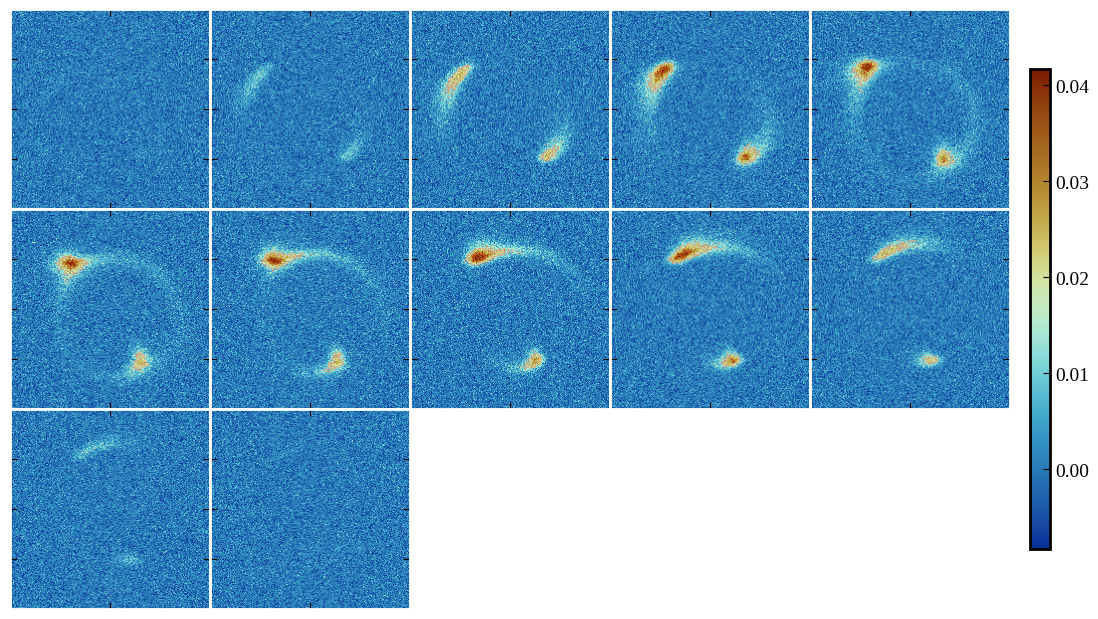

In [8]:
# plot channel maps
n_cols = 5
n_chan = mock_lensed_cube_conv.shape[0]
n_rows = int(np.ceil(n_chan / n_cols))

start = 0

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols, 2*n_rows))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.0, hspace=0.0)
for i in range(n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['bottom'].set_color("white")
    ax.spines['top'].set_color("white")
    ax.spines['right'].set_color("white")
    ax.spines['left'].set_color("white")
    if i < n_chan:
        ax.imshow(mock_lensed_cube_conv[start+i], cmap=cm.roma_r, origin="lower", vmin=-2*rms, vmax=10*rms)
        ax.contour(mock_lensed_cube_conv[start+i]/rms, levels=[4, 8, 12, 16, 32], colors='red', alpha=0.7, linewidths=0.2)
        
        # ax.annotate(f"{int(vel_start+dv*i)}km/s", xy=(0.25, 0.87), xytext=(0, 0), color='white', xycoords='axes fraction', textcoords='offset points',weight='bold', ha='center', va='baseline', fontsize=25)
        # ellipse = Ellipse(xy=(0,0), width=BMAJ, height=BMIN, angle=BPA+90.,edgecolor='none', fc='white', lw=0.5)  # must be define any time
        # ax.add_patch(ellipse)
    
    # if i==0:
    #     size = 1/pix
    #     fontprops = fm.FontProperties(size=40)
    #     scalebar = AnchoredSizeBar(ax.transData,
    #                             size, r'1$^{\prime\prime}$', 'lower right',
    #                             pad=0.3,
    #                             sep=5,
    #                             color='white',
    #                             frameon=False,
    #                             size_vertical=2,
    #                             fontproperties=fontprops)
    #     ax.add_artist(scalebar)
    
    if i >= n_chan:
        ax.axis('off')

# 全体のカラーバー
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=-2*rms, vmax=10*rms)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cm.roma_r), cax=cbar_ax)

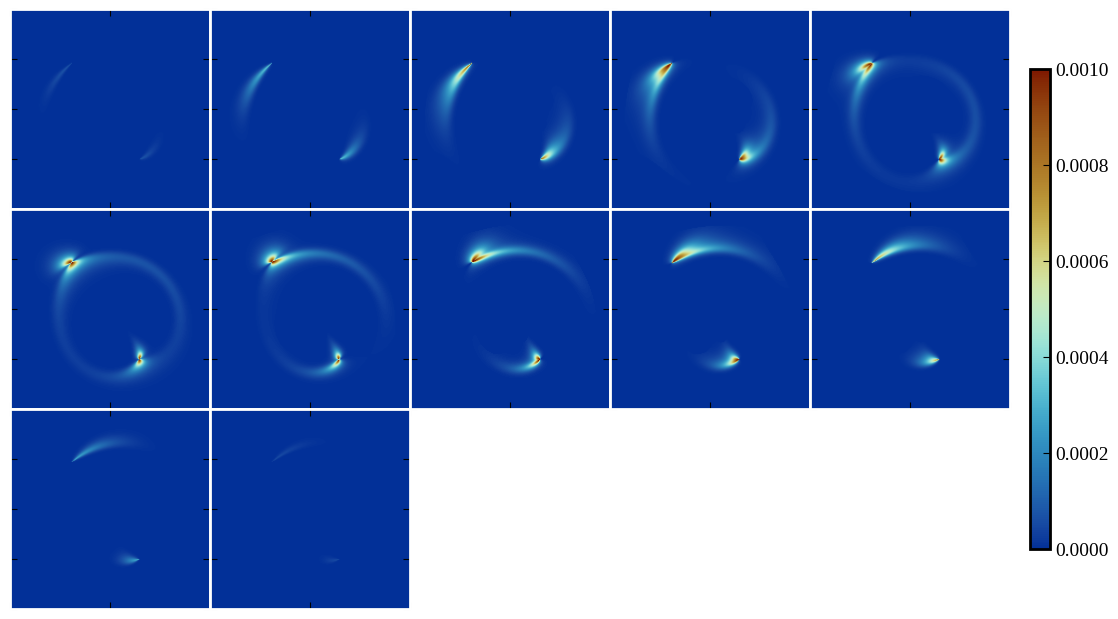

In [9]:
# plot channel maps
n_cols = 5
n_chan = mock_lensed_cube_conv.shape[0]
n_rows = int(np.ceil(n_chan / n_cols))

start = 0

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols, 2*n_rows))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.0, hspace=0.0)
for i in range(n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['bottom'].set_color("white")
    ax.spines['top'].set_color("white")
    ax.spines['right'].set_color("white")
    ax.spines['left'].set_color("white")
    if i < n_chan:
        ax.imshow(mock_lensed_cube[start+i], cmap=cm.roma_r, origin="lower", vmin=0, vmax=1e-3)
        # ax.contour(mock_lensed_cube[start+i]/rms, levels=[4, 8, 12, 16, 32], colors='red', alpha=0.7, linewidths=0.2)
        
    if i >= n_chan:
        ax.axis('off')

# 全体のカラーバー
cbar_ax = fig.add_axes([1.02, 0.1, 0.02, 0.8])  # [left, bottom, width, height]
norm = plt.Normalize(vmin=0, vmax=1e-3)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cm.roma_r), cax=cbar_ax)

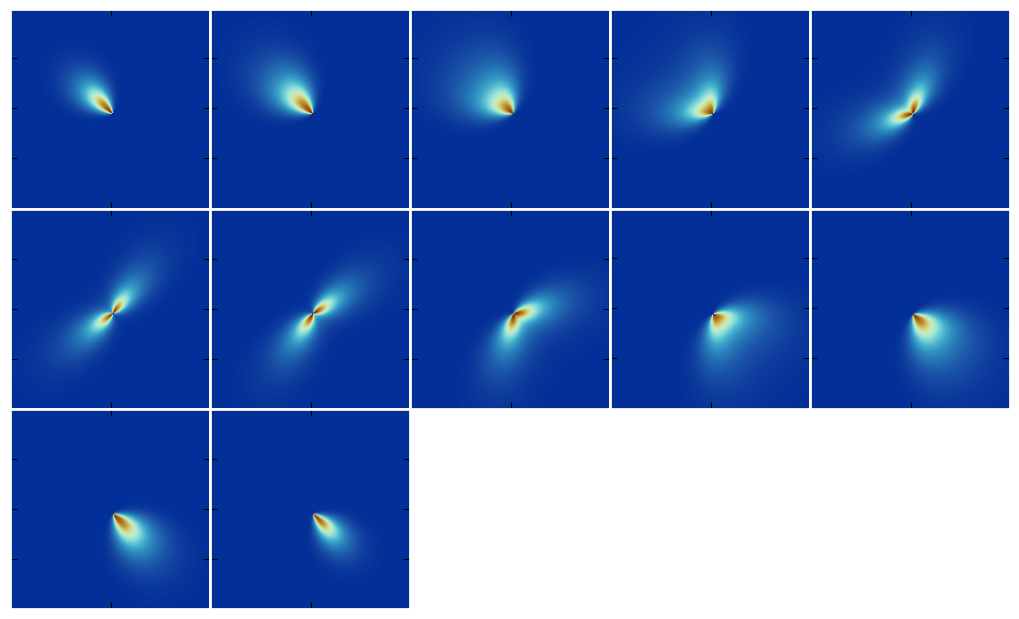

In [10]:
# plot channel maps
n_cols = 5
n_chan = mock_lensed_cube_conv.shape[0]
n_rows = int(np.ceil(n_chan / n_cols))

start = 0

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_cols, 2*n_rows))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, wspace=0.0, hspace=0.0)
for i in range(n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.spines['bottom'].set_color("white")
    ax.spines['top'].set_color("white")
    ax.spines['right'].set_color("white")
    ax.spines['left'].set_color("white")
    if i < n_chan:
        ax.imshow(mock_source[start+i], cmap=cm.roma_r, origin="lower")#, vmin=-0.5*rms, vmax=10*rms)
        # ax.contour(mock_lensed_cube_conv[start+i], level*rms, colors=linecolor, linestyles=linestyles, linewidths=linewidths)
        
        # ax.annotate(f"{int(vel_start+dv*i)}km/s", xy=(0.25, 0.87), xytext=(0, 0), color='white', xycoords='axes fraction', textcoords='offset points',weight='bold', ha='center', va='baseline', fontsize=25)
        # ellipse = Ellipse(xy=(0,0), width=BMAJ, height=BMIN, angle=BPA+90.,edgecolor='none', fc='white', lw=0.5)  # must be define any time
        # draw_ellipse(ax, ellipse)
    
    # if i==0:
    #     size = 1/pix
    #     fontprops = fm.FontProperties(size=40)
    #     scalebar = AnchoredSizeBar(ax.transData,
    #                             size, r'1$^{\prime\prime}$', 'lower right',
    #                             pad=0.3,
    #                             sep=5,
    #                             color='white',
    #                             frameon=False,
    #                             size_vertical=2,
    #                             fontproperties=fontprops)
    #     ax.add_artist(scalebar)
    
    if i >= n_chan:
        ax.axis('off')

## Reconstruction

In [11]:
x0 = param_table[:,0]
lb = param_table[:,1]
ub = param_table[:,2]
ndim = len(lb)

In [14]:
from glint.inference import logprior_box


def loglike(theta):
    model = forward_model_image(theta, ctx)[2]
    diff = (mock_lensed_cube_conv - model) * noisedata_inv
    chi2 = np.sum(diff[:, maskdata]**2)
    return -0.5 * chi2


def logprob(theta):
    lp = logprior_box(theta, lb, ub)
    if not np.isfinite(lp):
        return -np.inf
    ll = loglike(theta)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll

In [ ]:
chain, logprob, sampler = run_emcee(logprob_fn=logprob, x0=x0, lb=lb, ub=ub, nwalkers=4*len(lb), burnin=2000, production=100000, ncpu=32, init_frac=0.2)


savename = f"./mcmc_chain_mock_cube_image.npz"
np.savez(savename,
         chain=chain,
         logprob=logprob,
         param_names=param_names)

print(f"MCMC chain saved to {savename}.")

  5%|▌         | 53/1000 [00:12<03:35,  4.39it/s]Process ForkPoolWorker-64:
Process ForkPoolWorker-43:
Process ForkPoolWorker-57:
Process ForkPoolWorker-51:


emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-36:


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-45:


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-44:
Process ForkPoolWorker-55:


emcee: Exception while calling your likelihood function:emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-63:
Process ForkPoolWorker-52:
Process ForkPoolWorker-61:
Process ForkPoolWorker-49:


emcee: Exception while calling your likelihood function:

Process ForkPoolWorker-46:
Process ForkPoolWorker-53:
Process ForkPoolWorker-60:
Process ForkPoolWorker-59:


emcee: Exception while calling your likelihood function:


KeyboardInterrupt: 

## Corner plot

In [ ]:
import numpy as np
import corner
import matplotlib.pyplot as plt

# ===============================
# 1. Load saved chain
# ===============================

savename = f"./mcmc_chain_mock_cube_image.npz"
npzfile = np.load(savename, allow_pickle=True)

chain = npzfile["chain"]              # shape: (nsteps, nwalkers, ndim)
logprob = npzfile["logprob"]          # shape: (nsteps, nwalkers)
param_names = list(npzfile["param_names"])

print("Loaded chain:")
print(" chain shape:", chain.shape)
print(" logprob shape:", logprob.shape)
print(" ndim:", len(param_names))


# ===============================
# 2. Truth parameters（mock_params）をここで明示的に入れる
# ===============================

mock_params = np.array([
    mock_x_s, mock_y_s, mock_F_0, mock_inc_deg, mock_pa_deg, mock_r_scale,
    mock_v_c, mock_r_turn, mock_gamma_curve, mock_sigma_0, mock_r_sigma,
    mock_vsys_kms, mock_b, mock_q_l,
    mock_pa_l, mock_log_gamma, mock_pa_gamma
])

print("\nTruth parameters loaded:")
for name, val in zip(param_names, mock_params):
    print(f" {name:12s} = {val:.4f}")


# ===============================
# 3. Flatten chain
# ===============================

nsteps, nwalkers, ndim = chain.shape
flat_chain = chain.reshape((-1, ndim))

print("\nFlattened chain shape:", flat_chain.shape)


# ===============================
# 4. Corner plot
# ===============================

fig = corner.corner(
    flat_chain,
    labels=param_names,
    truths=mock_params,
    show_titles=True,
    smooth=1.0,
    smooth1d=1.0,
    plot_density=True,
    plot_datapoints=False,
    title_fmt=".3f",
    title_kwargs={"fontsize": 12},
)

fig.savefig("corner_mock_lens_fix.pdf", dpi=200, bbox_inches="tight")
plt.show()

print("\nSaved corner plot: corner_mock_lens_fix.pdf")

# ===============================
# 5. 真値 vs 最尤推定値
# ===============================

# 最も logprob が大きい点を best-fit とする
idx = np.unravel_index(np.argmax(logprob), logprob.shape)
best_theta = chain[idx[0], idx[1], :]

print("\n==============================")
print(" Best-fit parameters vs Truth")
print("==============================")

for name, best, truth in zip(param_names, best_theta, mock_params):
    print(f"{name:12s}  best={best:10.4f}   truth={truth:10.4f}   Δ={best-truth:+.4f}")

print("\nCompleted comparison.")

In [ ]:
### rotation curve with error band ###
# サンプルから rotation curve を計算
from tqdm import tqdm
n_samples = flat_chain.shape[0]
radius_rc = np.arange(0, 0.8+1e-6, 0.01) # 0含める

# 5個おきのサンプルだけ使う
idx = np.arange(0, n_samples, 5)

vrot_samples = []
for i in tqdm(range(0, n_samples, 5)):
    params = flat_chain[i]
    v_c = params[6]
    r_turn = params[7]
    gamma_curve = params[8]
    vrot_samples.append(Vrot_Courteau1997(r=radius_rc, v_c=v_c, r_turn=r_turn, gamma=gamma_curve, beta=1.0))
vrot_samples = np.array(vrot_samples)
vrot_median = np.median(vrot_samples, axis=0)
vrot_16 = np.percentile(vrot_samples, 16, axis=0)
vrot_84 = np.percentile(vrot_samples, 84, axis=0)   

fig, ax = plt.subplots(figsize=(5,3))
ax.plot(radius_rc, vrot_median, color='blue', label='Best-fit rotation curve')
ax.fill_between(radius_rc, vrot_16, vrot_84, color='blue', alpha=0.3, label='1$\sigma$ uncertainty')
ax.plot(radius_rc, Vrot_Courteau1997(r=radius_rc, v_c=mock_v_c, r_turn=mock_r_turn, gamma=mock_gamma_curve, beta=1.0), color='red', linestyle='--', label='True rotation curve')
ax.set_xlabel('Radius  /arcsec', fontsize=14)
ax.set_ylabel(r'Rotation Velocity  /km s$^{-1}$', fontsize=14)
ax.legend(fontsize=12)
ax.set_ylim(300, 520)
fig.savefig("rotation_curve_mock_lens_fix.pdf", dpi=200, bbox_inches="tight")
print("Saved to ./rotation_curve_mock_lens_fix.pdf")
plt.show()

## Compare models and observations

In [ ]:
# model with best-fit parameters
best_source, best_lensed_cube_conv = forward_model_cube(best_theta)

# Plot cube for each channel
# Some settings for plotting
vmax = np.nanmax(mock_lensed_cube_conv)
width = 2
titles = ["Truth", "Model", "Residual", "Source"]


fig, axes = plt.subplots(nchan, ncols=4, figsize=(width*4, width*nchan))
fig.subplots_adjust(wspace=0., hspace=0.0)
for i in range(nchan):
    im0 = axes[i, 0].imshow(mock_lensed_cube_conv[i], cmap=cm.roma_r, origin="lower", vmin=-2*rms, vmax=vmax)
    axes[i, 0].contour(mock_lensed_cube_conv[i]/rms, levels=[8,16,32], colors='black', linewidths=1.0)
    im1 = axes[i, 1].imshow(best_lensed_cube_conv[i], cmap=cm.roma_r, origin="lower", vmin=-2*rms, vmax=vmax)
    im2 = axes[i, 2].imshow((mock_lensed_cube_conv[i] - best_lensed_cube_conv[i]) / rms, cmap=cm.roma_r, origin="lower", vmin=-3, vmax=3)
    im3 = axes[i, 3].imshow(best_source[i], cmap=cm.roma_r, origin="lower", vmin=0, vmax=np.nanmax(best_source))

    if i==0:
        for j in range(4):
            axes[i, j].set_title(titles[j], fontsize=14, pad=-2)
    for j in range(4):
        # divider = make_axes_locatable(axes[i,j])
        # cax = divider.append_axes("right", size="5%", pad=0.)
        # fig.colorbar([im0, im1, im2, im3][j], cax=cax)
        axes[i, j].set_xticklabels([])
        axes[i, j].set_yticklabels([])

    
fig.savefig("channel_maps_mock_lens_fix.pdf", dpi=200, bbox_inches="tight")
print("Saved to ./channel_maps_mock_lens_fix.pdf")
# plt.tight_layout()